<a href="https://colab.research.google.com/github/malcolmlett/ml-learning/blob/main/visualisations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training Instrumentation Toolkit: Visualisations
Being able to easily and quickly visualise the internal behaviours of the training algorithm makes all the difference when optimising and troubleshooting your training algorithm.

This toolkit is not intended to replace any of the well established tools out there, but to show how I think they should be extended. In the meantime, I've tried to make it easy to get up and running with some basic matplotlib-style visualisations as out-of-box functionality within the toolkit. These are visualisations that I've found useful myself.

This notebook illustrates the visualisations that are provided out of the box.

Feel free to take this as a basis for your own.

In [1]:
# Install Training Instrumentation Toolkit
import os
import sys
if not os.path.isdir('training-instrumentation-toolkit'):
  !git clone https://github.com/malcolmlett/training-instrumentation-toolkit.git
sys.path.append('training-instrumentation-toolkit')

# Imports
import train_instrumentation as tinstr
import keras
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras import layers, models, datasets, optimizers, metrics
import numpy as np
import matplotlib.pyplot as plt
import math
import sklearn
import sklearn.datasets

# Run some unit tests
# (no formal packaging in the toolkit as yet, so just a rudimentary manual execution of tests)
import train_instrumentation_test
train_instrumentation_test.run_test_suite()

Cloning into 'training-instrumentation-toolkit'...
remote: Enumerating objects: 1242, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 1242 (delta 0), reused 1 (delta 0), pack-reused 1239 (from 1)
Receiving objects: 100% (1242/1242), 84.80 MiB | 16.64 MiB/s, done.
Resolving deltas: 100% (749/749), done.
All train_observability_toolkit tests passed.


## Instrumented Training Run
We'll use a simple binary classification problem, against the commonly used "circles" dataset.

We won't go into details about the various options for instrumentation in this notebook. See the _Instrumentation_ notebook for that.

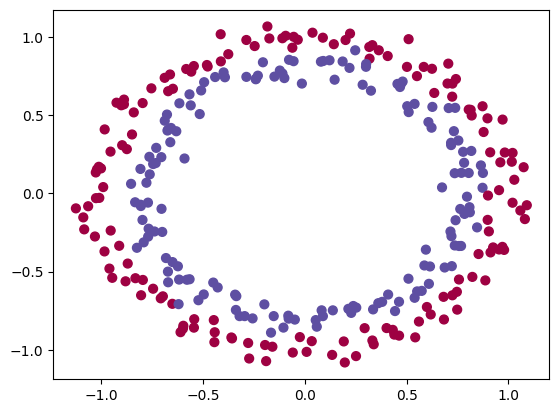

In [11]:
# Using a slightly more elaborate model than needed for such a simple task in order
# to illustrate how dropout and normalization layers appear in visualisations
def binary_classification_model():
  model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(2,)),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(5, activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer='he_normal')
  ])
  return model

def binary_classification_dataset():
  np.random.seed(1)
  train_X, train_Y = sklearn.datasets.make_circles(n_samples=300, noise=.05)
  train_X = train_X
  train_Y = train_Y.reshape((-1, 1))
  return train_X, train_Y

train_X, train_Y = binary_classification_dataset()
plt.scatter(train_X[:, 0], train_X[:, 1], c=train_Y, s=40, cmap=plt.cm.Spectral);
plt.show()

In [18]:
# Run a full training sequence and collect default information for each of the four main callbacks.
# We'll also use the extended `HistoryStats` callback for loss and metric history.
variables = tinstr.VariableHistoryCallback()
gradients = tinstr.GradientHistoryCallback()
outputs = tinstr.LayerOutputHistoryCallback()
output_gradients = tinstr.LayerOutputGradientHistoryCallback()

model = binary_classification_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'mse'])
train_X, train_Y = binary_classification_dataset()
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y)).batch(32)
history = tinstr.fit(model, dataset, epochs=1000, verbose=0, callbacks=[tinstr.LessVerboseProgressLogger(), variables, gradients, outputs, output_gradients, tinstr.HistoryStats(per_step=True)])

# PS: any tf.function retracing warnings can be safely ignored.

Epoch   100 - 337.06ms/epoch: accuracy: 0.9600  loss: 0.1157  mse: 0.0319  
Epoch   200 - 283.32ms/epoch: accuracy: 0.9733  loss: 0.0498  mse: 0.0146  
Epoch   300 - 251.90ms/epoch: accuracy: 0.9867  loss: 0.0323  mse: 0.0100  
Epoch   400 - 239.20ms/epoch: accuracy: 0.9900  loss: 0.0386  mse: 0.0092  
Epoch   500 - 243.07ms/epoch: accuracy: 0.9833  loss: 0.0371  mse: 0.0121  
Epoch   600 - 236.15ms/epoch: accuracy: 0.9767  loss: 0.0460  mse: 0.0145  
Epoch   700 - 238.43ms/epoch: accuracy: 0.9967  loss: 0.0128  mse: 0.0032  
Epoch   800 - 259.35ms/epoch: accuracy: 0.9867  loss: 0.0320  mse: 0.0100  
Epoch   900 - 250.71ms/epoch: accuracy: 0.9833  loss: 0.0349  mse: 0.0115  
Epoch  1000 - 234.59ms/epoch: accuracy: 0.9933  loss: 0.0186  mse: 0.0061  


## Overview plot
The _overview plot_ tries to automatically give a birds-eye-view of everything important, including potential problems.

The function just takes a list of callbacks that have been used during training, and will plot whatever it can from that information. For more details, see the function pydocs.

The interpretation of the individual charts will be explained below.

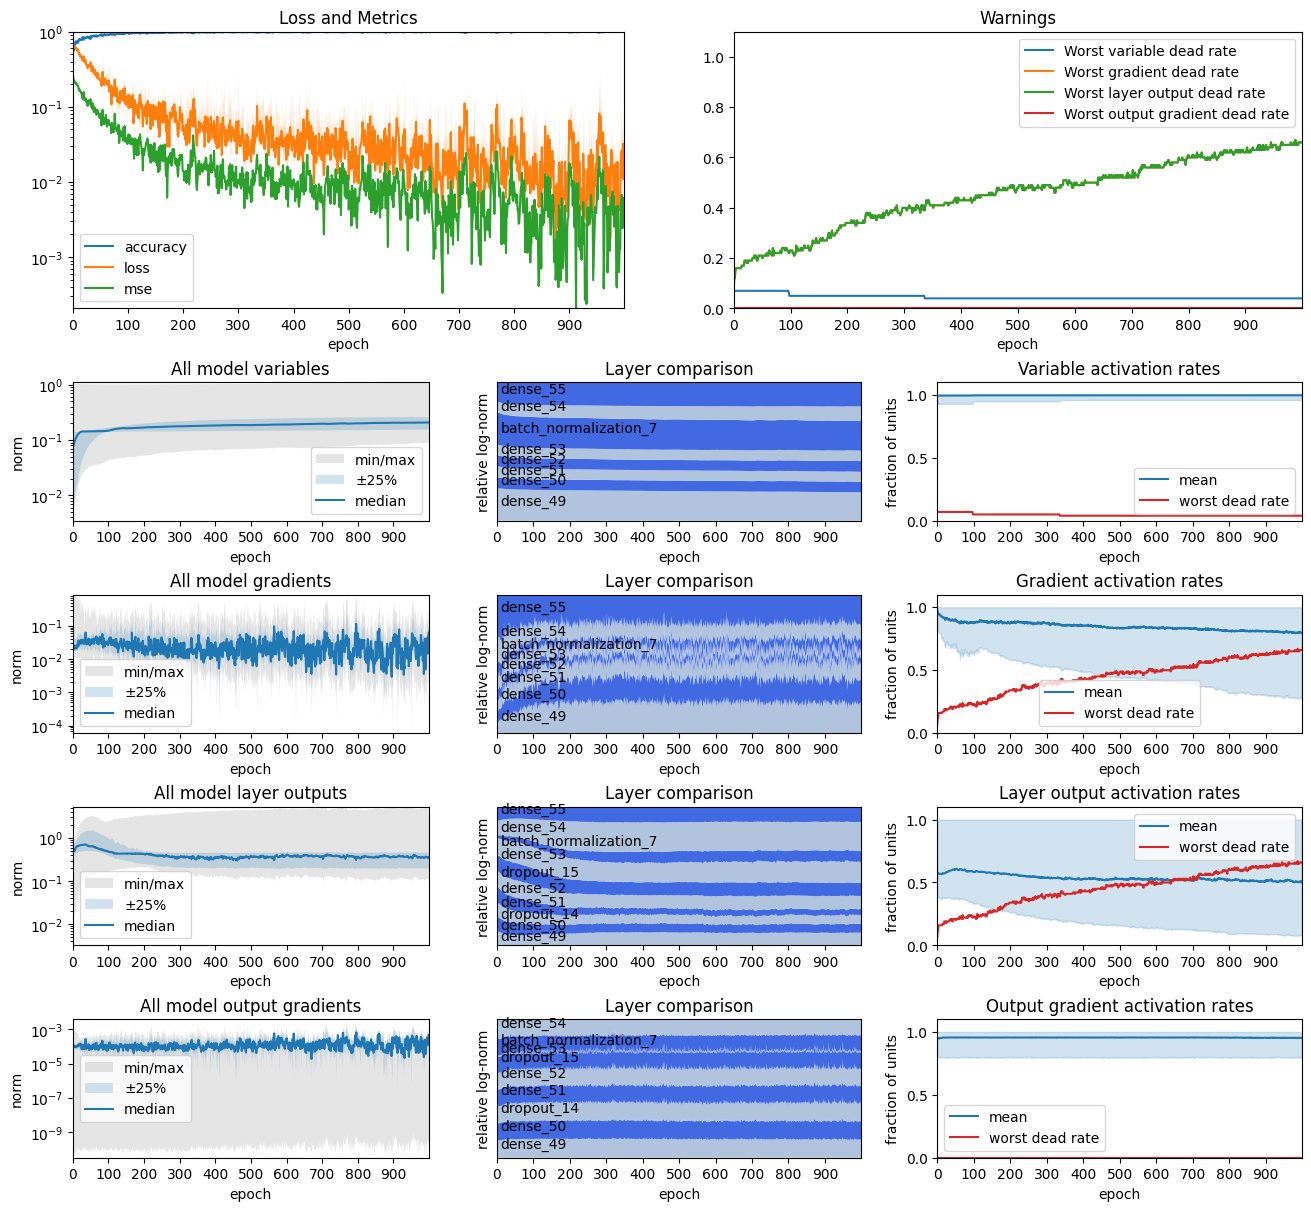

In [19]:
tinstr.plot_history_overview([history, variables, gradients, outputs, output_gradients])

Some of the layers are not well utilised - with about a 60% death rate by the end of training. Perhaps we've overprovisioned the capacity of this network.

## History Plots
The extended `HistoryStats` callback collects the usual loss and metrics every epoch. It also collects the same every update step, and makes that available for display of the distribution of those values per-epoch. This can be important because the early indicators of gradient oscillations can be hidden by the averaging effects of per-epoch metrics.

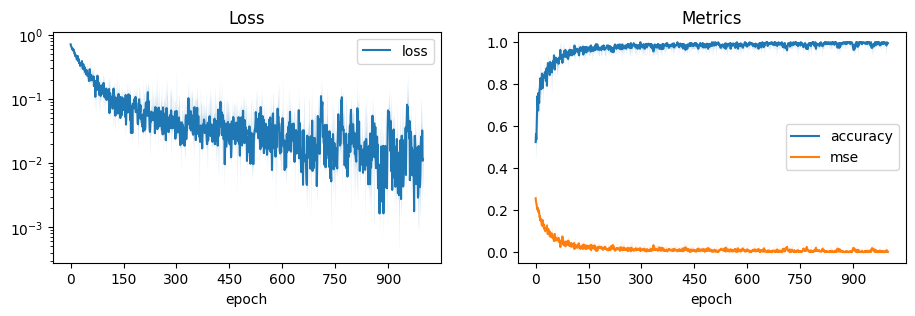

In [20]:
tinstr.plot_train_history(history)

It's hard to see, but the plots above include a +/- 25% range (ie: 25th to 75th percentiles), and a min/max range. However, the +/- 25% extents are hidden underneath the median loss values. Only the min/max range is visible, and it doesn't extend much out from the medians.

So everything looks fine here. In other doc notebooks I'll show where the distributions can be more useful.

In the meantime, we can still see the distribution if we zoom in on a narrower range:

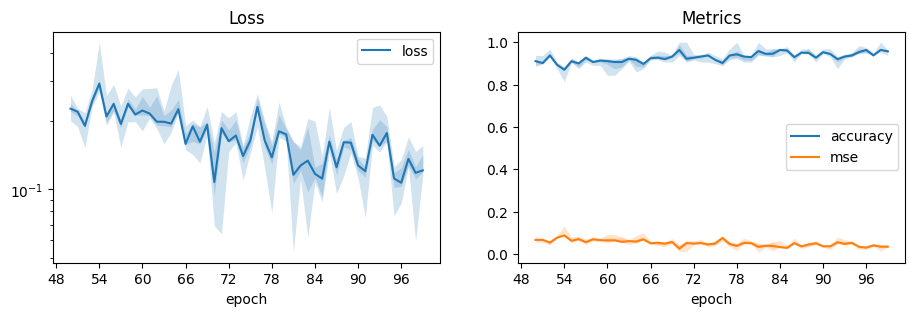

In [41]:
tinstr.plot_train_history(history, iterations=range(50,100))

Plotting of distributions can be turned off if needed:

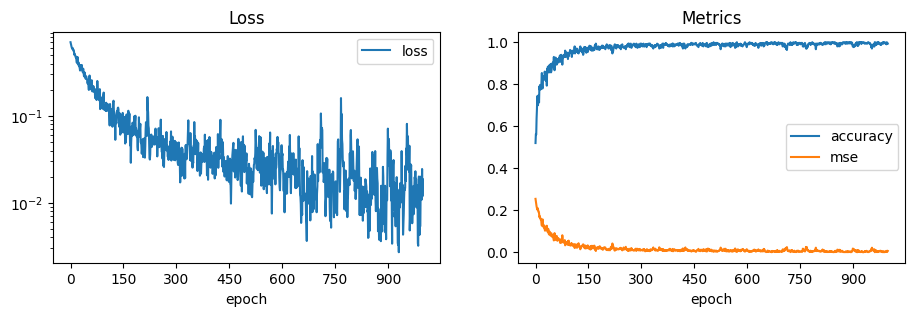

In [21]:
tinstr.plot_train_history(history, show_loss_percentiles=False, show_metric_percentiles=False)

By training with `per_step=True` in `tinstr.HistoryStats(per_step=True)` we also retain the raw per-step loss and metrics. Usually this is too much information for long training runs, but it can be useful on shorter runs when you want to see the per-step variance for yourself.


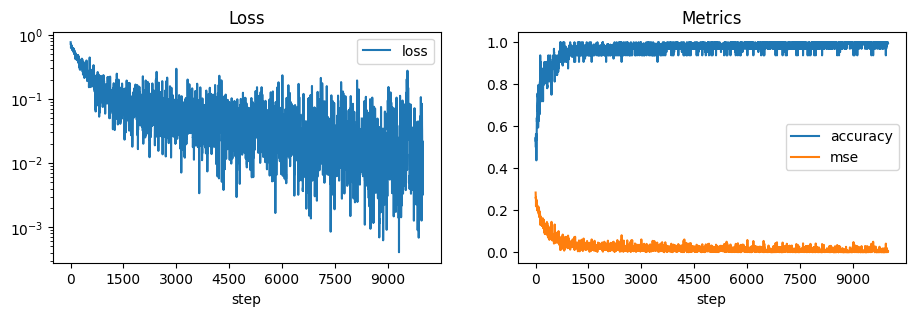

In [22]:
tinstr.plot_train_history(history, per_step=True)

Again, for this long training run it's hard to see anything meaningful there. Plotting per-step loss and metrics is usually more useful when you're troubleshooting on a short run...or when you want to narrow in on a particular period and see the details:

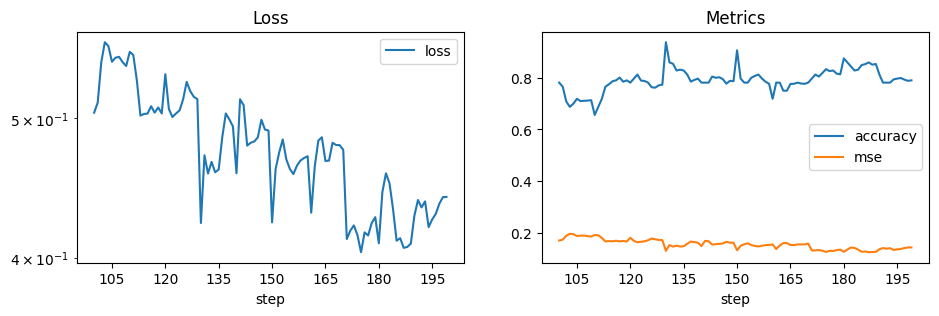

In [39]:
tinstr.plot_train_history(history, per_step=True, iterations=range(100,200))

## Value Plots
The four main callbacks collect stats on the values of four key quantites:
* layer weights and biases (aka variables)
* layer outputs
* gradients w.r.t. the weights and biases
* gradients w.r.t. the layer outputs

Being able to visualise how these values change during the course of training can be extremely useful for troubleshooting problems.

These are often very large and multi-dimensional tensors, so visualising them in a way that gives easy insight can be hard. Here I'll explore a few ways that they can be visualised. I'll explore the options via the main gradients (w.r.t weights and biases) first.

Since these values are multi-dimensional and large, people seek a way to simplify their representation. The academic literature most often uses the _L2-norm_ of the tensors (technically, the multi-dimensional extension of the frobenius norm, also known as the euclidean norm). For example, assuming that the dimensions of tensor $T$ are indexed via $i..s$ we have:
$$
\text{norm} = \sqrt{ \sum_{i...s} T_{i..s}^2}
$$

In a neural network, the layers are often normalized one way or another to have a consistent per-element mean, but they may differ significantly in tensor size. For easier comparison across layers and across network architectures, I thus prefer to normalize the norm by the tensor size, giving this equation (where $||T||$ = cardinality of $T$, or the total number of elements within $T$):
$$
\text{size-normalized-norm} = \frac{\sqrt{ \sum_{i...s} T_{i..s}^2}}{\sqrt{||T||}}
$$

Now we can plot the size-normalized norms of gradients for all trainable variables (weights, biases, other) across all layers:


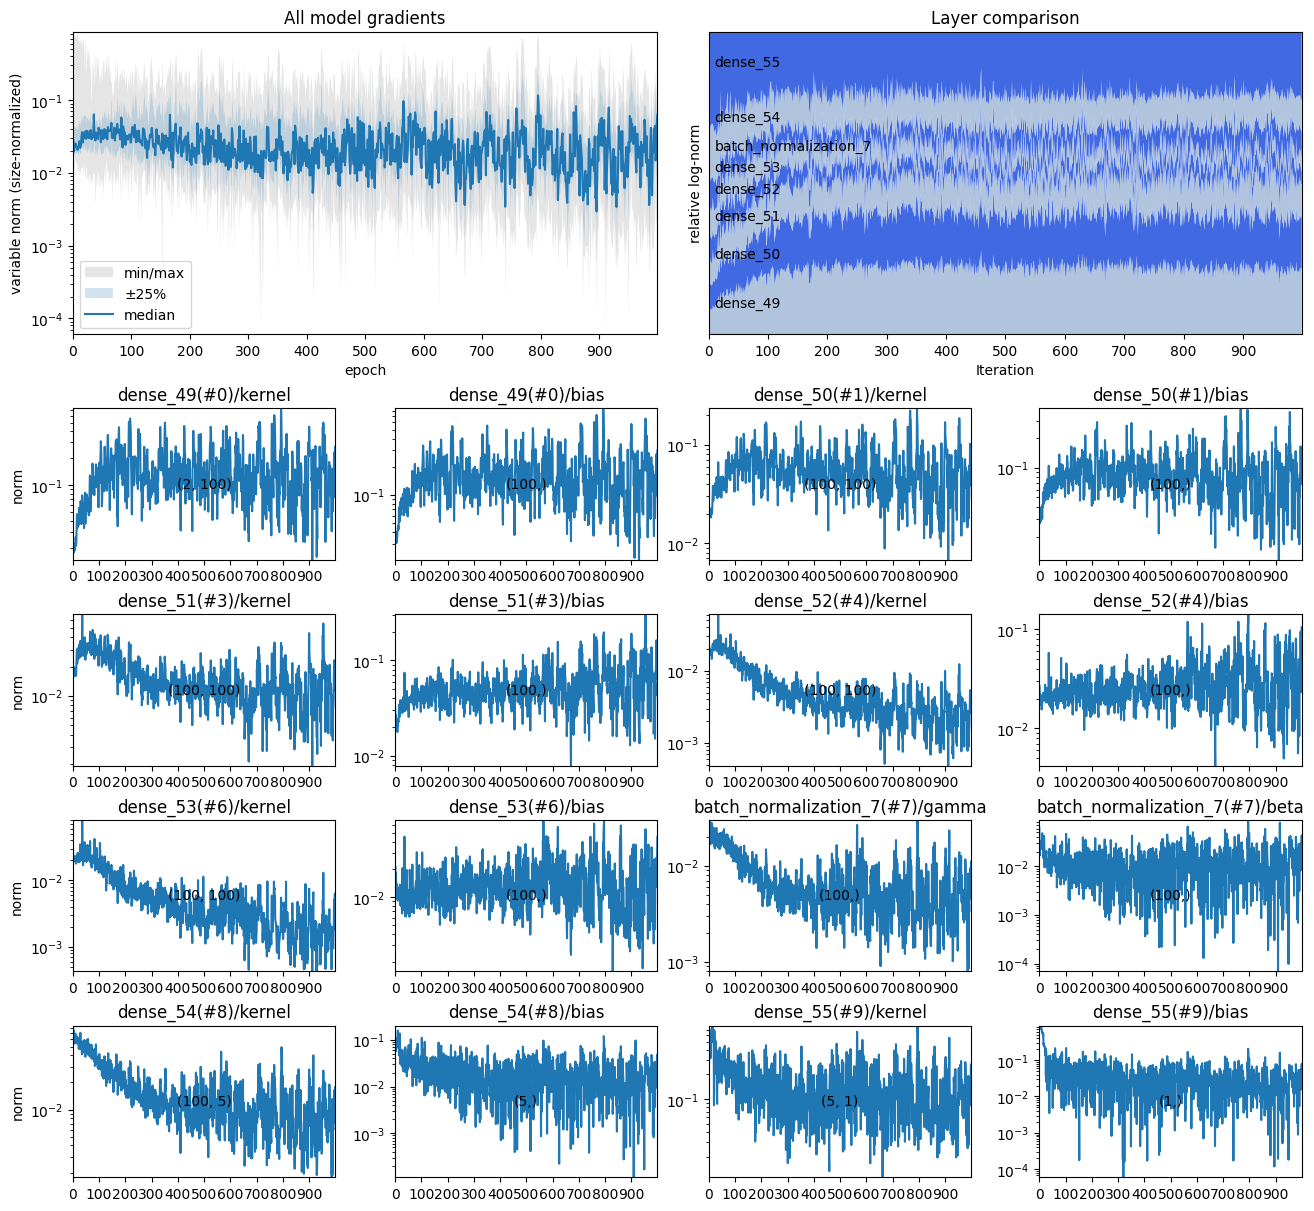

In [43]:
tinstr.plot_value_history(gradients, show='norms')

Some commentary on each of the charts:
* All model gradients:
  * this provides a quick overview of the general trend across the entire model by plotting the distribution of the norms across all variables.
* Layer comparison:
  * This is useful to check for signs of vanishing or exploding gradients.
  * The plot is constructed by taking the log of the norms, rescaling all values relative to the smallest value, and then stacking the values.
  * The smallest horizontal band defines 1 order of magnitude. A band that is twice the height is 10x larger, and a band that is three times the height of the smallest band is 100x larger.
  * Many other studies have found that the plot above is quite typical - larger gradients in the first and last layers few layers and smaller gradients towards the middle.
* Individual layer charts:
  * Each individual variable gets its own chart. A typical layer has two variables, a `kernel` tensor (aka weights) and a `bias` vector. The shapes of the tensors are overlayed on the charts.
  * Batch normalization also has two trainable tensors, a `gamma` and a `beta`.


In practice, I find that showing only the norm of the gradient tensors hides a lot of useful information. I often want to know the actual distribution of per-element values. One way to do that would be to show the distribution of raw values:

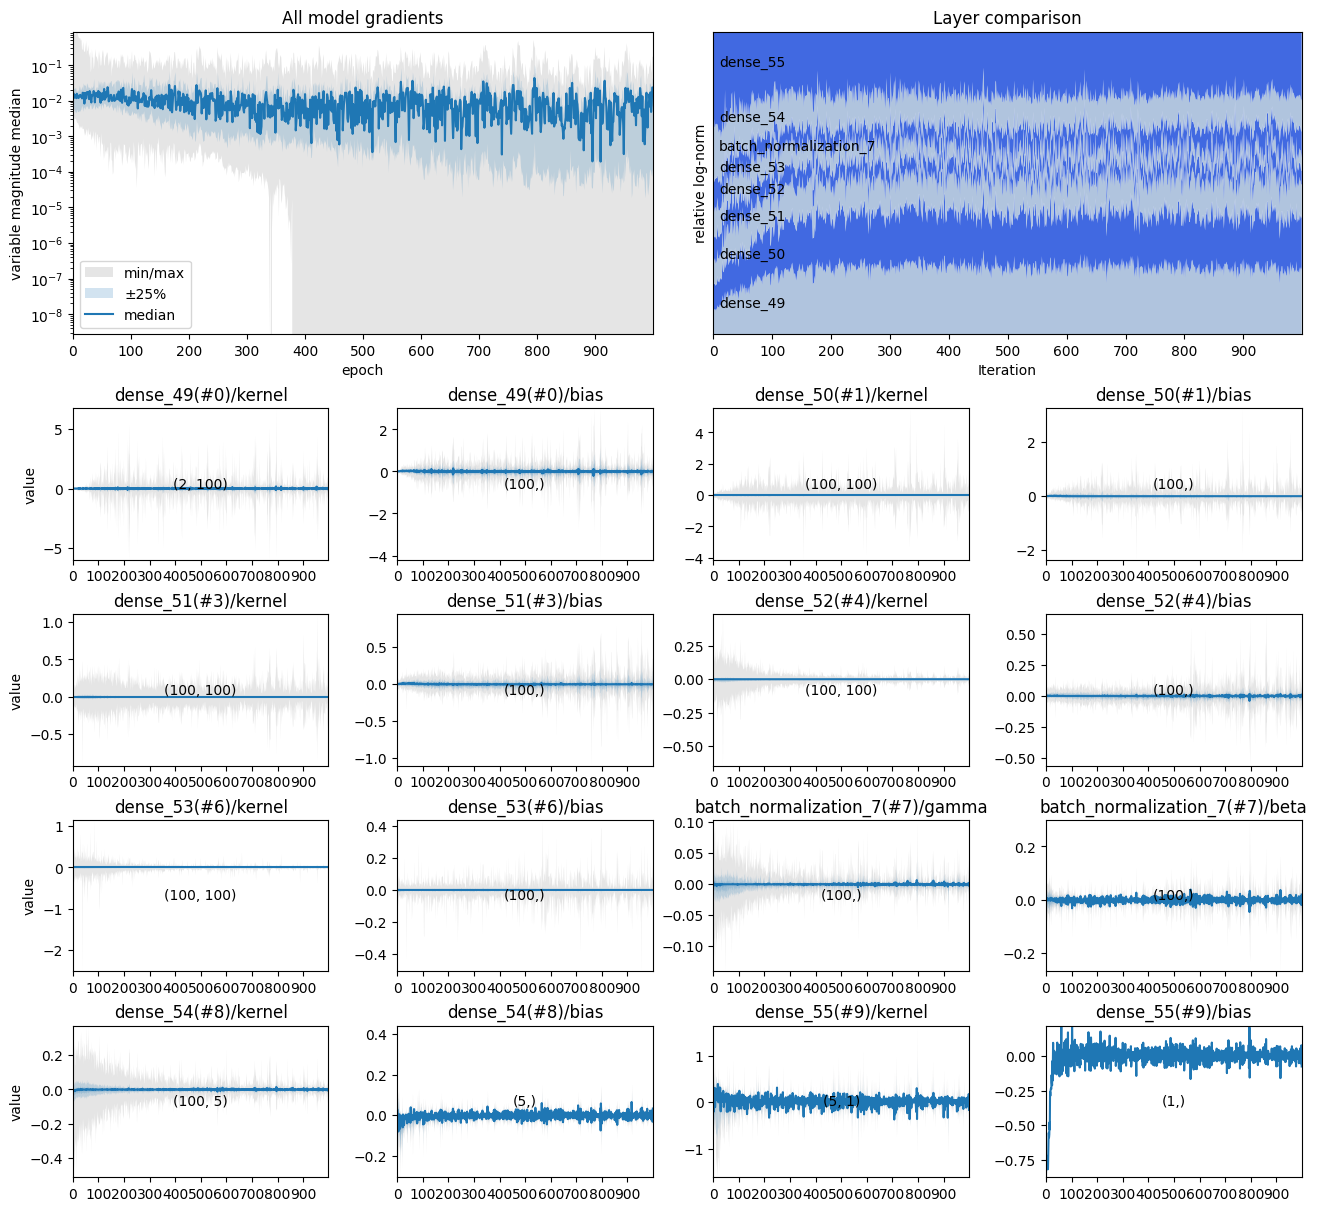

In [44]:
tinstr.plot_value_history(gradients, show='values')

In neural networks, quantities like gradients (and the others too) typically have quite extreme distributions, with the vast majority very close to the mean, but with very large tails. This makes it hard to see anything meaningful when plotting the distributions of the raw values.

My preferred plot shows the logs of the absolute magnitudes of the values.
This is in fact the default for `plot_value_history()`.

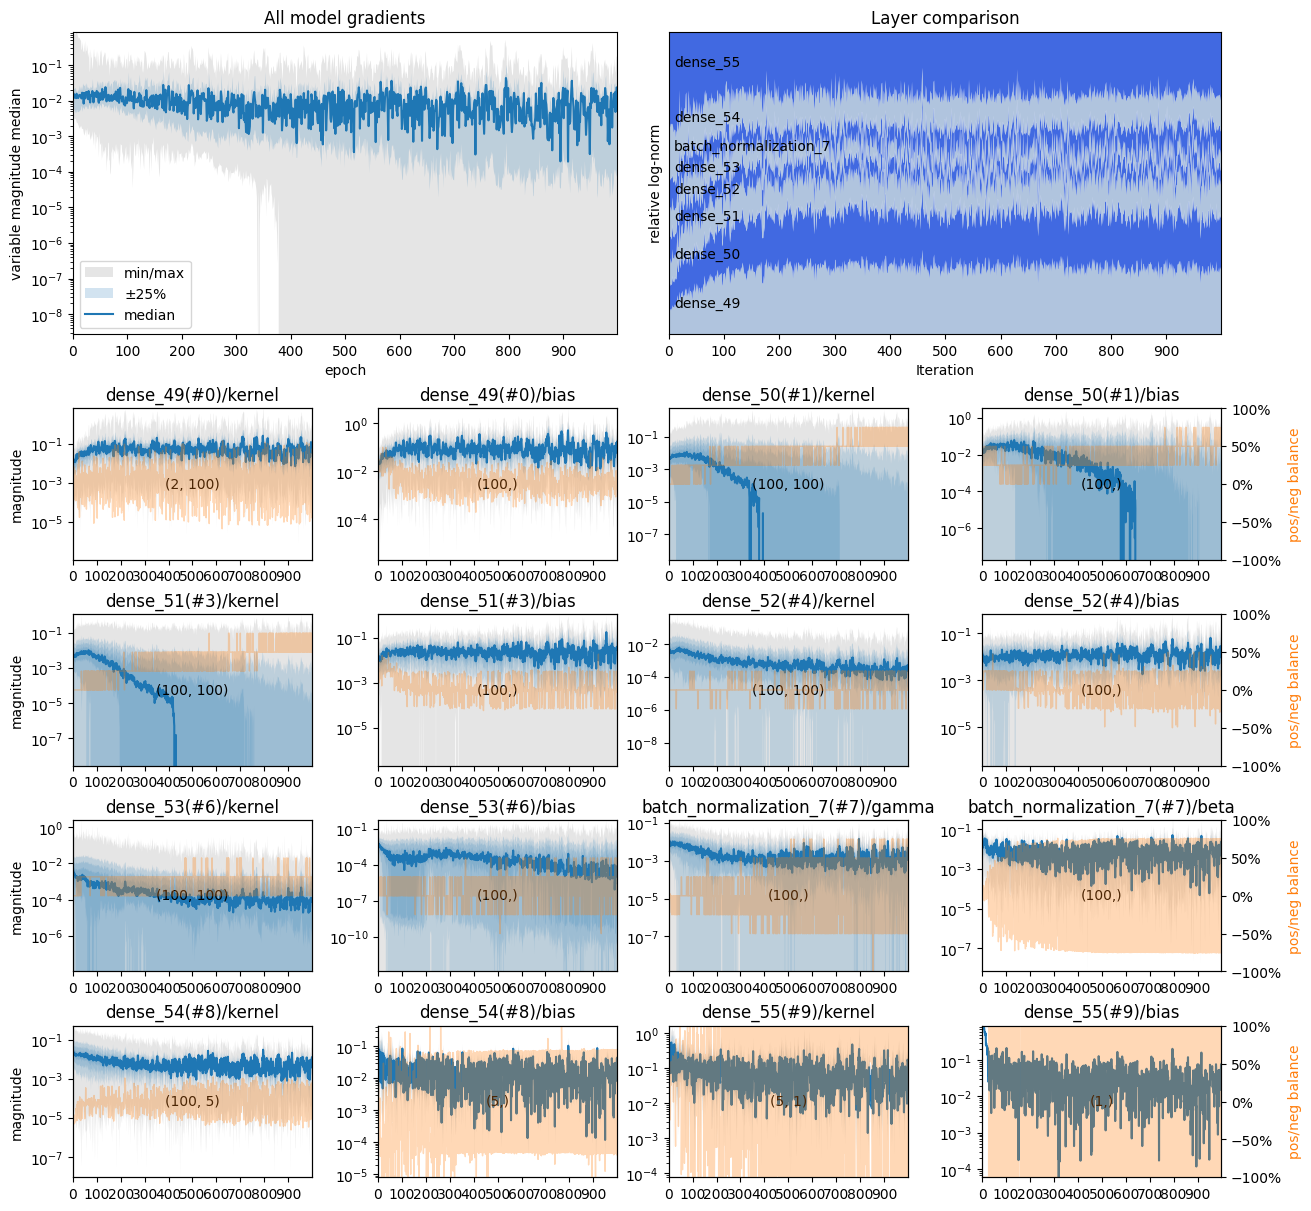

In [45]:
tinstr.plot_value_history(gradients, show='magnitudes')

**Pos/neg balance**

The problem with displaying absolute-magnitude data is that you loose information about the sign of the values. Occasionally this can be important. The `pos/neg balance` overlay on the plots above attempt to fill that gap. On the secondary axis, 0% means that values are evenly distributed between positive and negative, +100% means that all values are positive, and -100% means that all values are negative.

Notice that gradients on large tensors usually sit very evenly either side of zero. But the gradients for the small tensors at the end of this classification network swing rapidly between positive and negative. That could be an indication of problems.

**Zero gradients**

Another observation from these plots is that the median gradients of some variables has dropped off the chart. That's because the median gradient has gone to zero for those variables. We'll return to that briefly in this notebook when looking at activity rates.

For a more lengthy discussion, see the notebook on neuron death.

For now, let's just quickly zoom in and have a closer look at the narrow range of epochs when this happens:

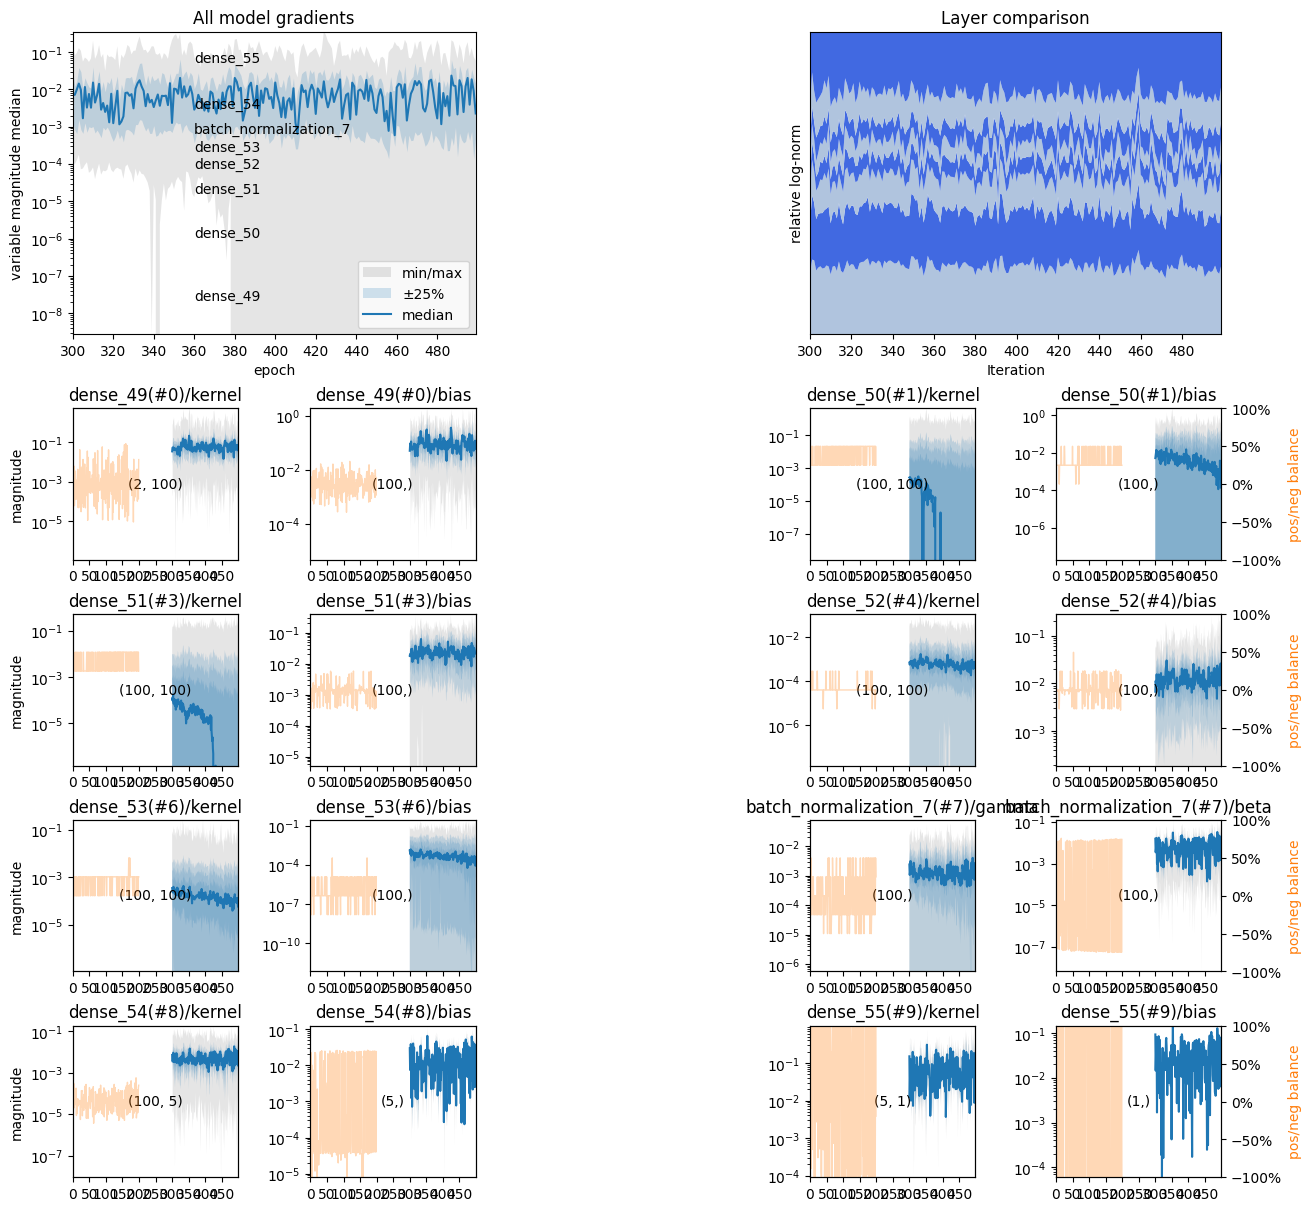

In [46]:
tinstr.plot_value_history(gradients, show='magnitudes', iterations=range(300,500))

**!doh!** looks like I have a bug.
Ok. Moving on.

**Variables**

Let's now quickly see what the value plots show for the other measurables, starting with the weights and biases.

I'll only list the log-magnitude plots now, but remember that norms and even raw values can be plotted for each.


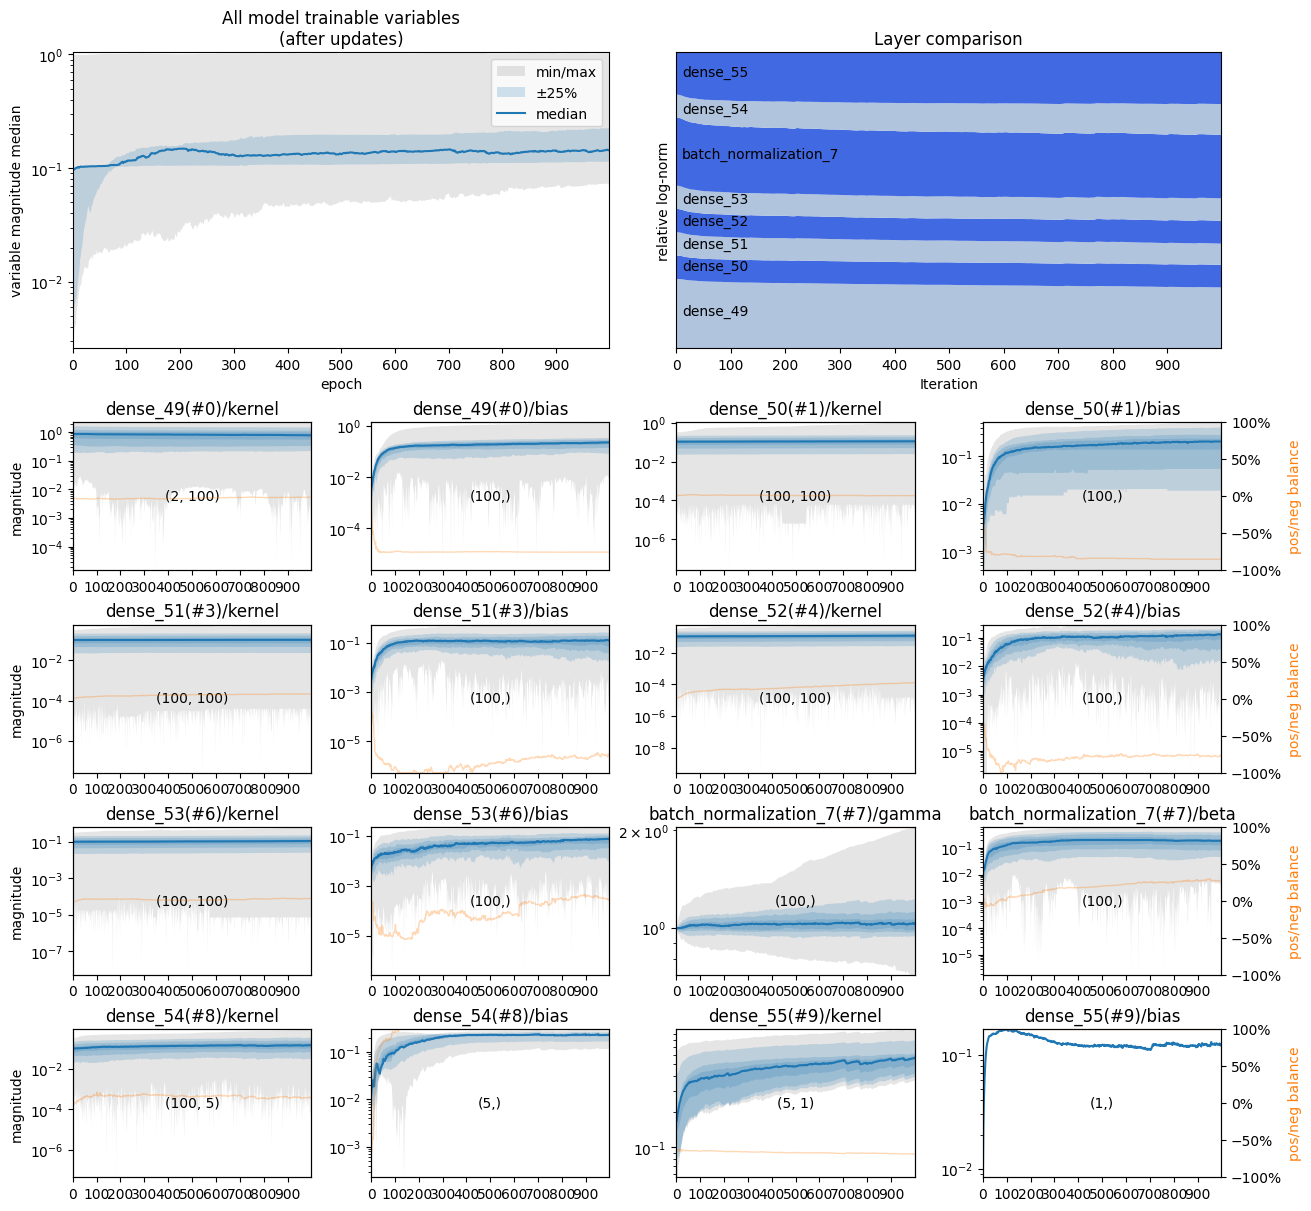

In [47]:
tinstr.plot_value_history(variables)

**Layer outputs**

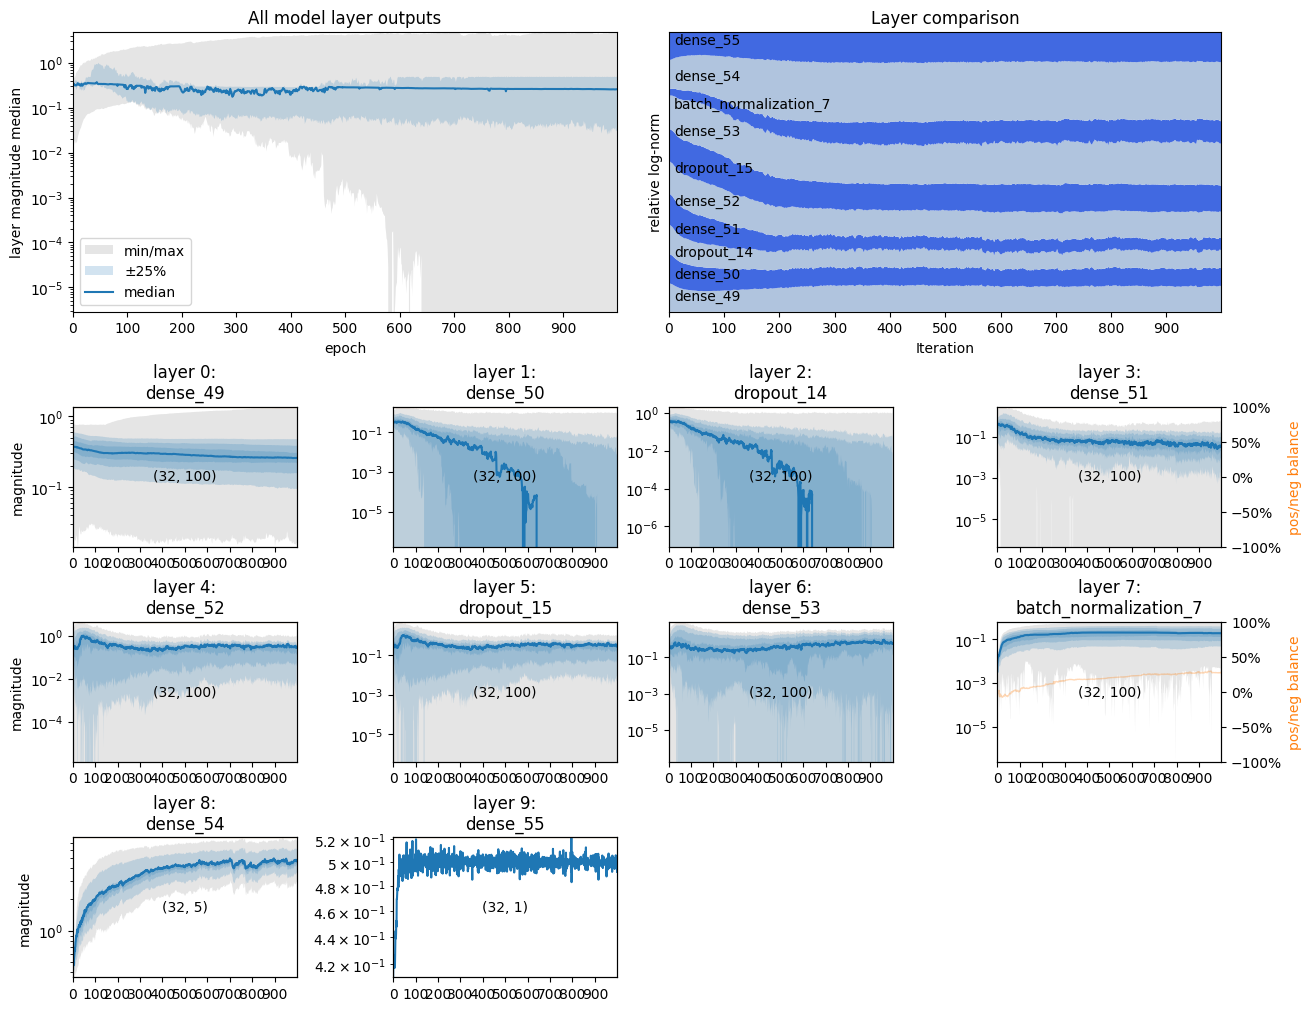

In [48]:
tinstr.plot_value_history(outputs, show='magnitudes')

**Gradients w.r.t. layer outputs**

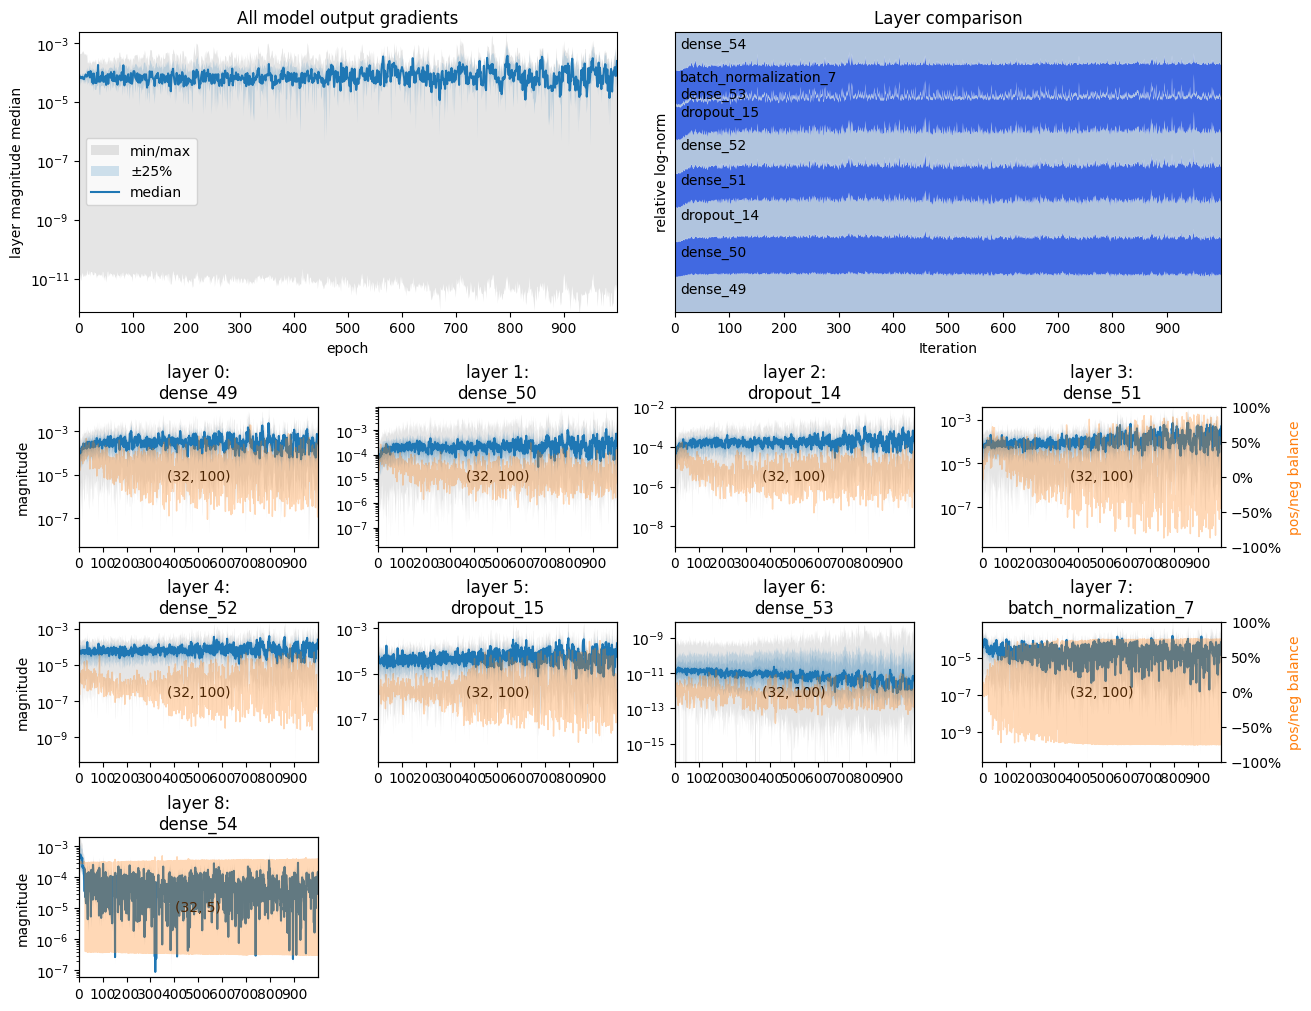

In [49]:
tinstr.plot_value_history(output_gradients, show='magnitudes')

## Activity Plots
Something that I find extremely enlightening for monitoring network training is to examine the percentage of units that are active for any given data sample. Some units are active almost all the time. Some units are only active for a percentage of samples. Some units are never active.

Units that are never active are known as "dead neurons". And neuron death is a problem for networking training. At its most inoccuous, neuron death reduces the capacity of a network and can slow down training. At its worst, neuron death can lead to a total collapse of the model gradients - making it unable to train any further.

What do I mean by unit?

In simple terms, a _unit_ is a single perceptron, with a number of weights applied to its inputs, a bias, and a single output. I measure the _activity_ of the unit by the percentage of samples for which it produces a non-zero output. ReLU units produce zero output for all cases where the pre-activation value is $\le 0$.

When trying to write generic code that can cope with all sorts of model architectures across all sorts of domains, I have to make some assumptions about how to interpret the output datastructures in order to translate those datastructures into the concept of a unit. I take the following assumptions:
* For weights, biases, and their gradients where there's no batch dimension, each tensor is assumed to have shape `(..spatial-dims.., units)`. For simple dense layers there's no spatial dimensions. For convolutional layers, "units" would be the number of output channels. For RNNs, at least one of the spatial dims is actually a time dimension, but it makes no difference.
* For layer outputs and their gradients, where there's a batch dimension, each tensor is assumed to have shape `(batches, ..spatial-dims.., units)`.
* For all of the above, a "unit" is a single perceptron with one unique set of weights and an optional bias. That perceptron may be used only once for each data sample (eg: dense layer), or it might be used repeatedly (eg: convolutional layer). I calculate activity as the percentage of non-zero outputs across all batch and all spatial dims.

I use _activity plots_ to visualise this.

Here's the activity plot for the gradients:

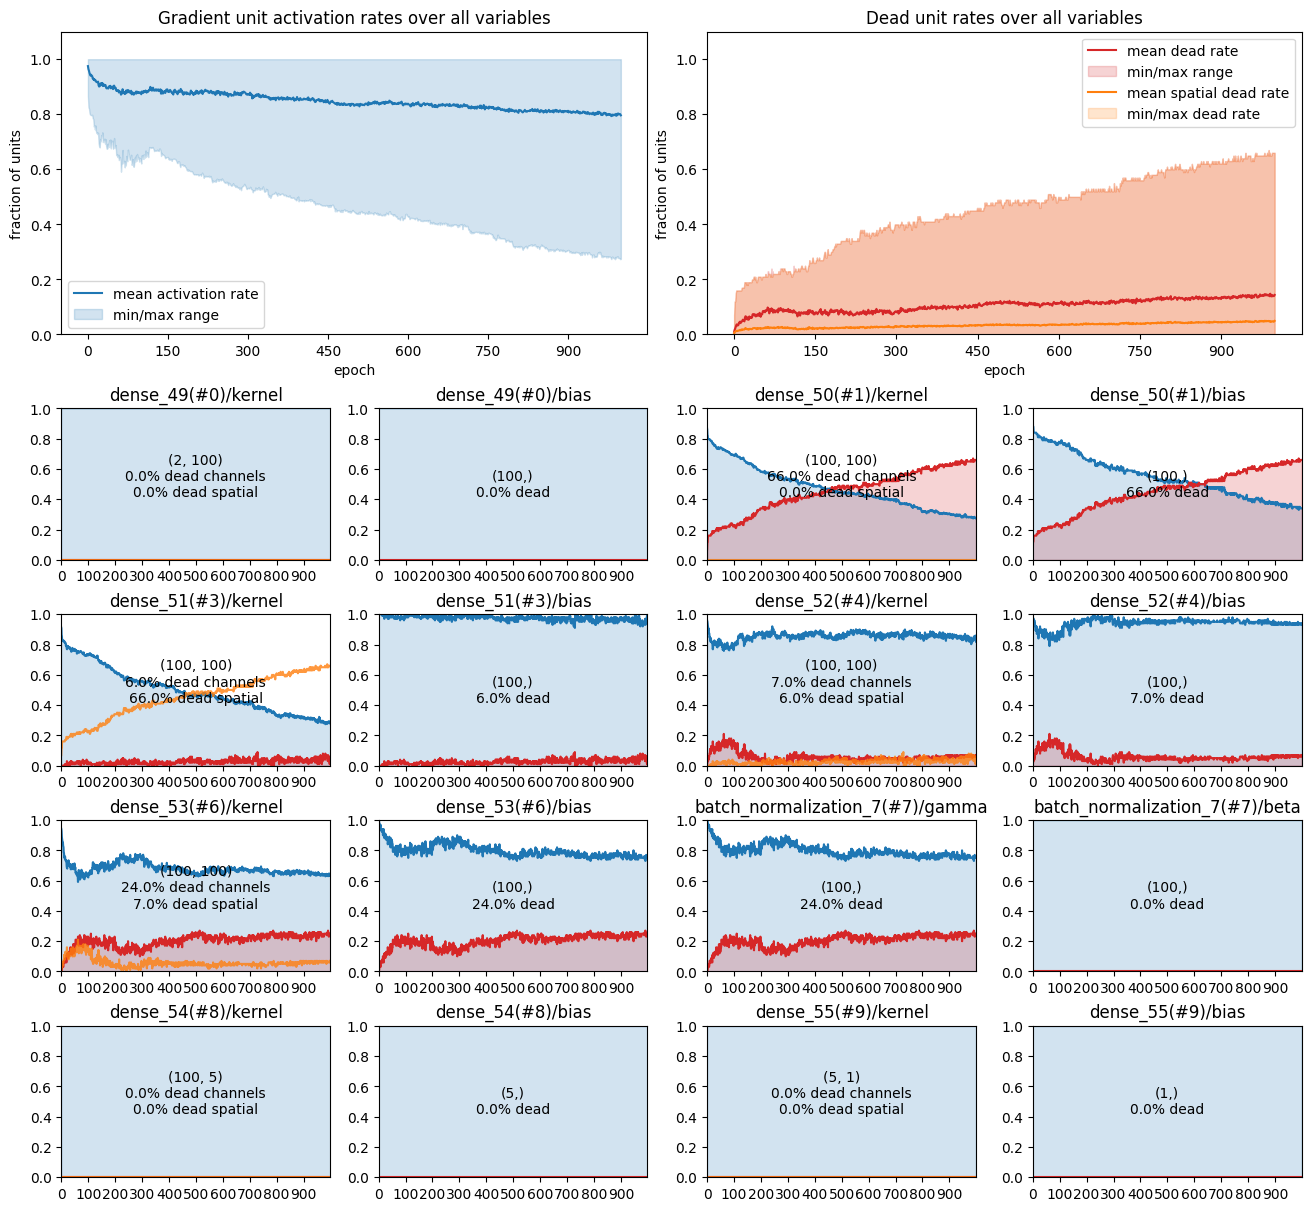

In [50]:
tinstr.plot_activity_history(gradients)

Some explanations:
* The blue series give the activity rate as the mean percentage of activity across all units, all batches, and all spatial dimensions (if any).
* The model-overview chart gives the model-wise mean of those values plus min/max range across all variables. For individual variables, it's just that variable's mean, with background shading for easier visability.
* The dead rate series (red) measure the percentage of units that are never active: zero across all batch and spatial dimensions. When viewing per-epoch results as in the above, that's also measured across the entire epoch. In other words, 24% dead means that 24% of units are simply never active, for any of the training data.
* For variables with spatial dimensions, I find it can sometimes be useful to also measure the dead rate as a factor of spatial dimension rather than as a factor of unit (orange series). This measures the percentage of spatial positions that are never active, across all samples and across all channels in that position.
* The charts are overlayed with the shape of the tensor, plus the final dead rate(s)

Some unit death is normal for any model. But large dead rates is a problem. I talk more about that in the Neuron Death notebook.

**Variable activity**

Again, we'll quickly run through activity plots of the other measurables.

First up, the weights and biases.

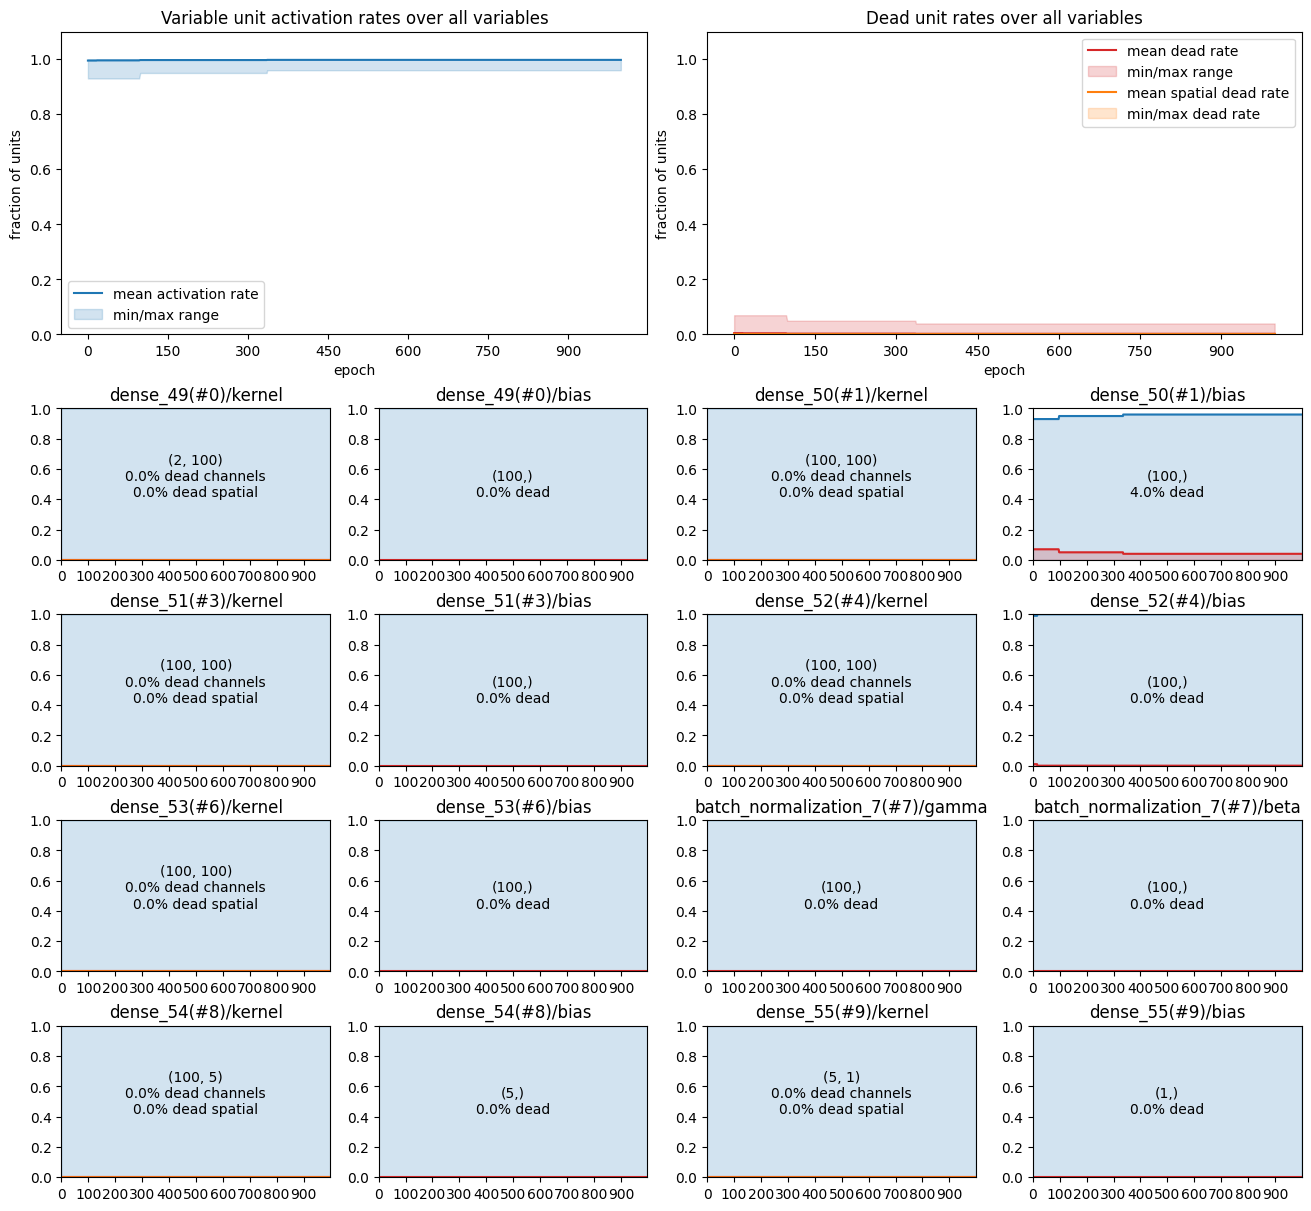

In [51]:
tinstr.plot_activity_history(variables)

**Layer outputs**

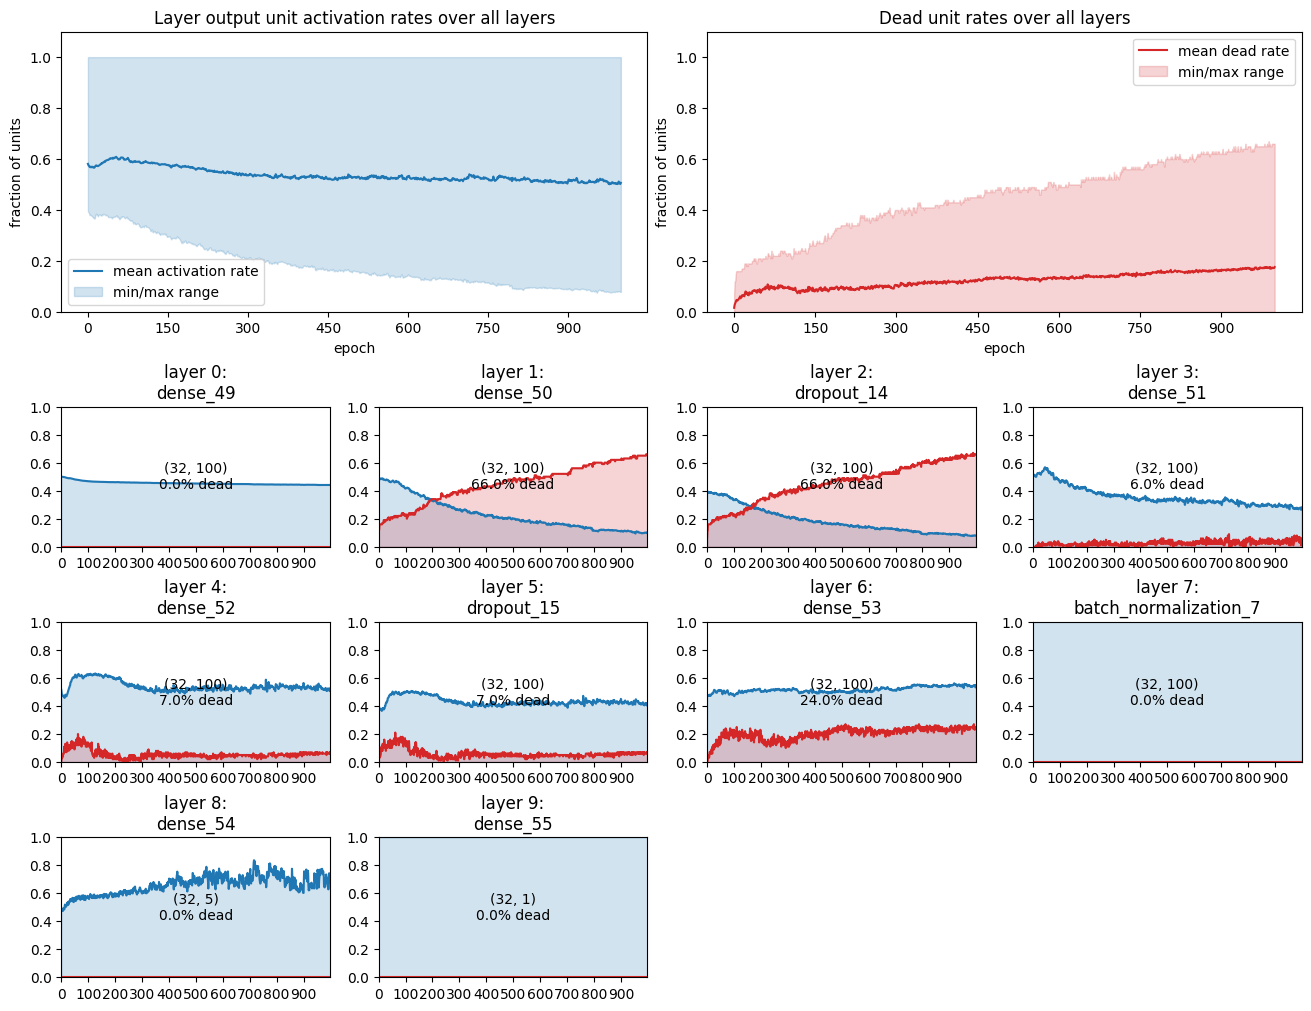

In [52]:
tinstr.plot_activity_history(outputs)

**Gradients w.r.t. layer outputs**

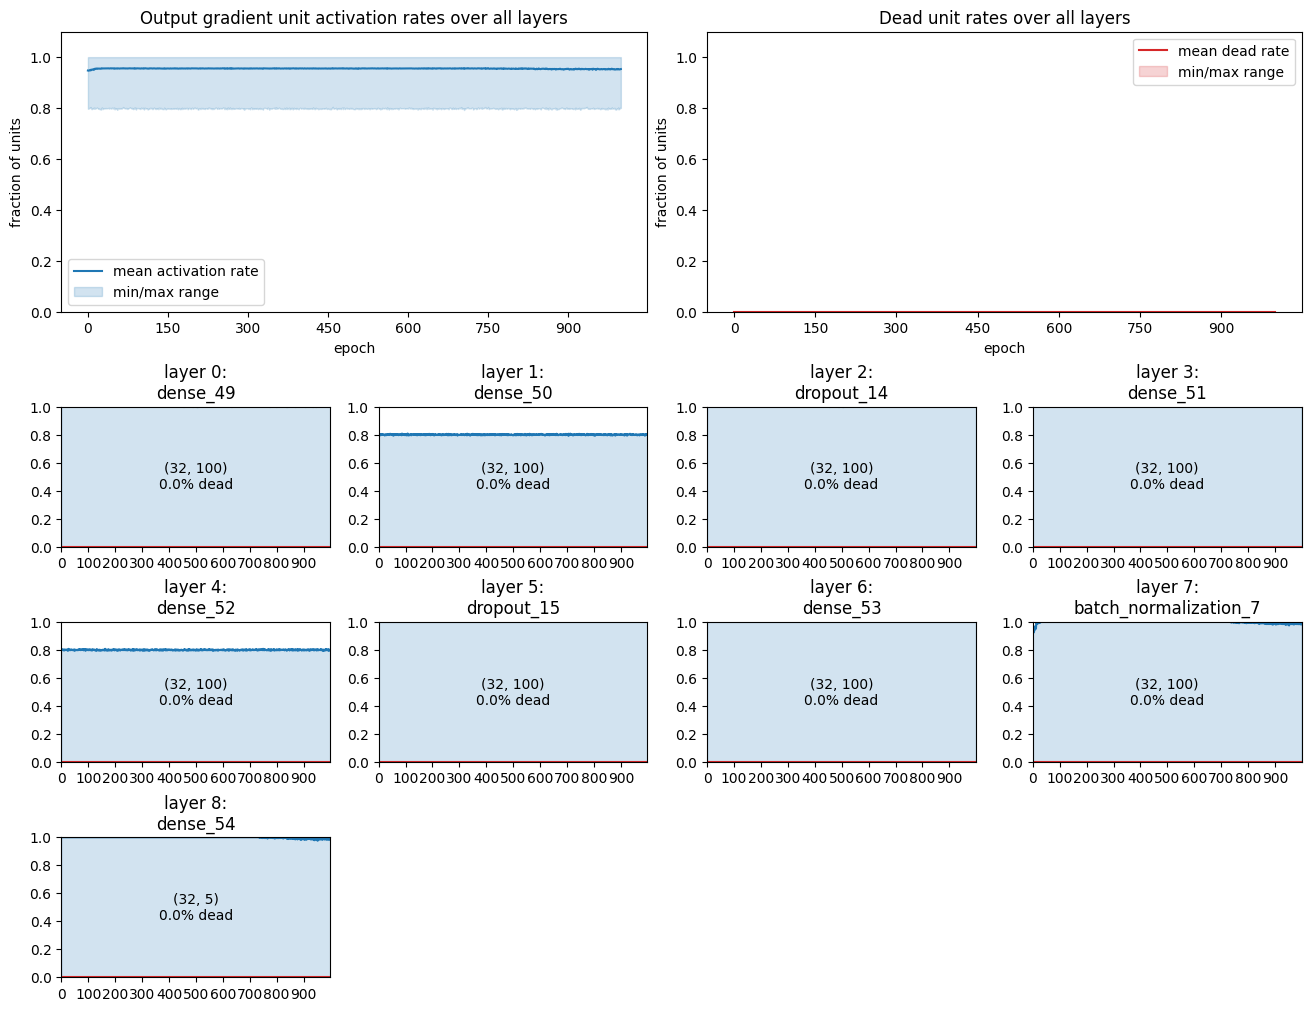

In [53]:
tinstr.plot_activity_history(output_gradients)

## Current activity rates

In my experimentations, I also sometimes found it useful to measure and plot the model's activity rates againts some dataset (could be training or test dataset). Whether this will be useful to others remains to be seen.

Regardless, I'll include an example below. And as always, you are free to use this as basis for your own visualisations.

But first, to get the most benefit, we'll need to train a CNN model.

In [64]:
def mnist_cnn_model():
  model = tf.keras.Sequential([
    layers.Input(shape=(28, 28)),
    layers.Reshape((28, 28, 1)),
    layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', strides=2, activation='relu'),
    layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', strides=2, activation='relu'),
    layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', strides=2, activation='relu'),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(10, activation='softmax')  # Output layer for 10 classes
  ])
  return model

# Load and normalize the data
def mnist_dataset():
  np.random.seed(1)
  (x_train, y_train), _ = tf.keras.datasets.mnist.load_data()
  x_train = x_train / 255.0
  return x_train, y_train

train_X, train_Y = mnist_dataset()
print(f"train_X: {train_X.shape}, train_Y: {train_Y.shape}")

train_X: (60000, 28, 28), train_Y: (60000,)


In [67]:
model = mnist_cnn_model()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
train_X, train_Y = mnist_dataset()
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y)).batch(64)
history = model.fit(dataset, epochs=10)

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8546 - loss: 0.4730
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9757 - loss: 0.0811
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9843 - loss: 0.0523
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9888 - loss: 0.0371
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9914 - loss: 0.0286
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9935 - loss: 0.0213
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9946 - loss: 0.0179
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9953 - loss: 0.0144
Epoch 9/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9955 - loss: 0.0128
Epoch 10/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9971 - loss: 0.0091


In [71]:
# measure various activity stats against the training dataset
model_stats, layer_stats, layer_channel_activity, layer_spatial_activity = tinstr.measure_unit_activity(model, dataset, include_channel_activity=True, include_spatial_activity=True)
model_stats

{'min_dead_rate': 0.0,
 'max_dead_rate': 0.15625,
 'mean_dead_rate': 0.025181361607142856,
 'min_activation_rate': 0.17411304,
 'max_activation_rate': 0.99998504,
 'mean_activation_rate': 0.35683826}

This first plot shows histograms of the activity rates across the units. It can be hard to decipher. The main thing to look out for is large bars when activation rate = zero.

It can also be interesting to compare to the same model before training.

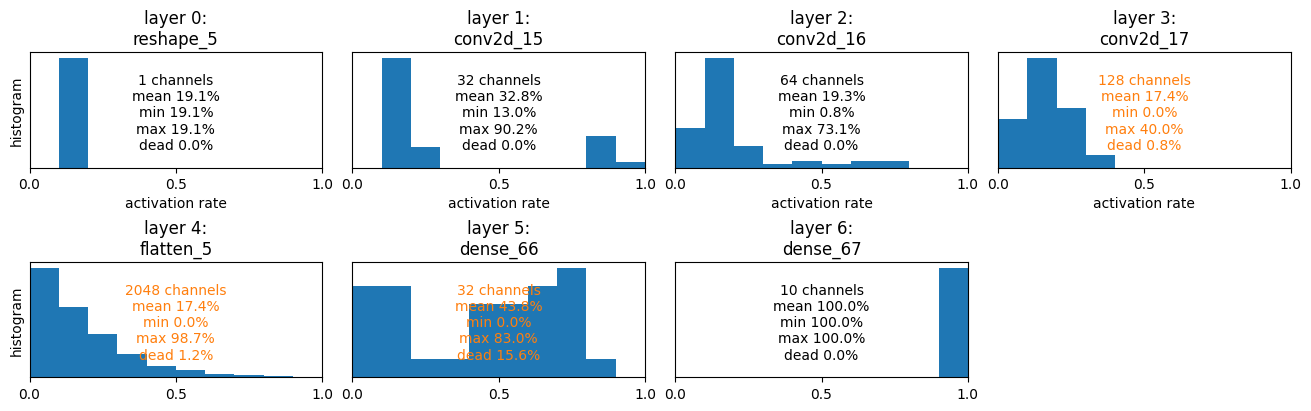

In [72]:
tinstr.plot_channel_stats(layer_channel_activity, model)

The second plot measures the activity rate w.r.t. spatial dimensions - it works best on 2D CNNs, which is why I switched to a CNN model.

In the following plot, each layer has two charts, one above the other. The first chart reflects the _mean_ activation rate across all samples and all output channels. The second chart indicates whether there are any "spatial dead units" (zero for all samples and all output channels). Where the layer has insufficient dimensions for a 2D plot, it just lists the stats.

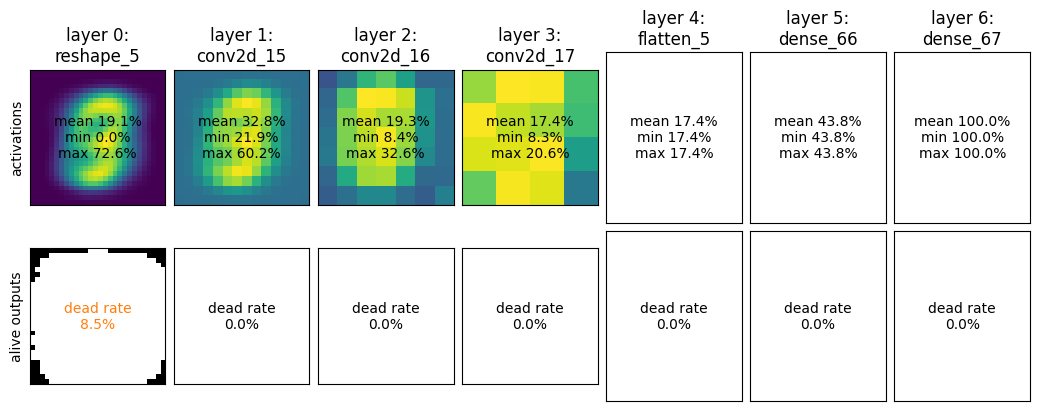

In [73]:
tinstr.plot_spatial_stats(layer_spatial_activity, model)

Notice that the border pixels on the input are never activated. This is pretty typical for image classification networks with data that has been pre-centred.

**Comparison to un-trained model**

It can sometimes be informative to compare the same to an untrained model.

In [74]:
model = mnist_cnn_model()
model_stats, layer_stats, layer_channel_activity, layer_spatial_activity = tinstr.measure_unit_activity(model, dataset, include_channel_activity=True, include_spatial_activity=True)
model_stats

{'min_dead_rate': 0.0,
 'max_dead_rate': 0.0009765625,
 'mean_dead_rate': 0.00013950892857142856,
 'min_activation_rate': 0.16378078,
 'max_activation_rate': 1.0,
 'mean_activation_rate': 0.43208796}

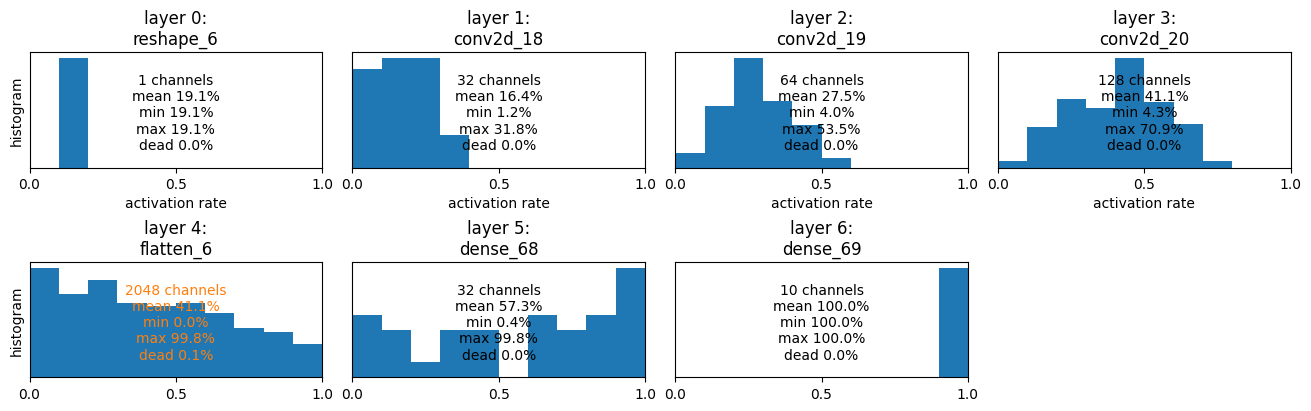

In [75]:
tinstr.plot_channel_stats(layer_channel_activity, model)

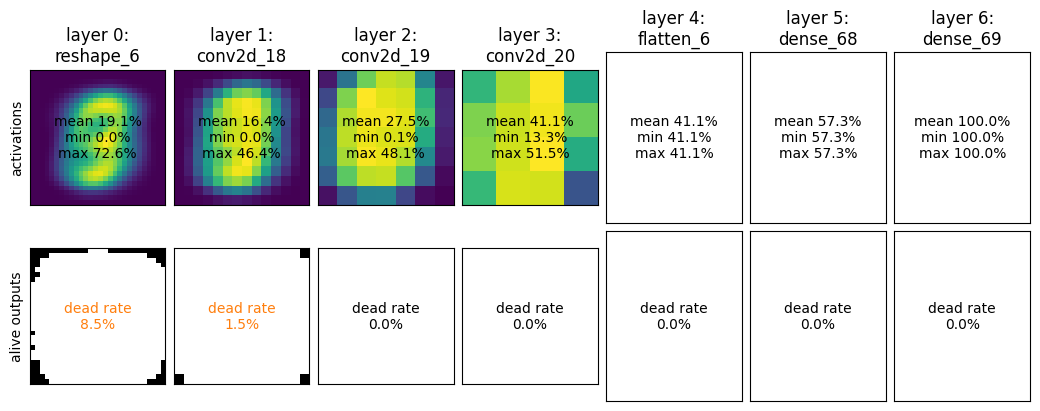

In [76]:
tinstr.plot_spatial_stats(layer_spatial_activity, model)

## Learning Rate

A final visualisation shows the _implicit learning rate_.

Optimizers such as Adam maintain their own set of tensors for calculating separate moments and/or other factors and use these to dynamically adjust the learning rates on a per-element basis. So, while we can set a single `learning_rate` parameter on the optimizer, there's really no such thing as a single single learning rate - rather, there's a distribution of learning rates.

The `LearningRateHistoryCallback` attempts to infer the individual per-element implicit learning rates and make them available for visualisation. The implicit learning rate isn't directly available without hacking into the optimizer under knowledge of its specific implementation. That's not very generic. So instead I calculate the implicit learning rate by measuring the gradients and the before/after state of the variables and then camputing the ilr for each variable, $V$ as:
$$
\text{ilr} = - \frac{\Delta{V}}{\frac{\partial V}{\partial J}}
$$

Here's an example comparing the results for a simple Stochastic Gradient Descent (no per-element implicit learning rates) and Adam.

First, with SGD:

In [94]:
ilr = tinstr.LearningRateHistoryCallback(per_step=False)

model = binary_classification_model()
model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
dataset = tf.data.Dataset.from_tensor_slices(binary_classification_dataset()).batch(32)
history = tinstr.fit(model, dataset, epochs=1000, verbose=0, callbacks=[tinstr.LessVerboseProgressLogger(), ilr])

Epoch   100 - 196.50ms/epoch: accuracy: 0.8167  loss: 0.3442  
Epoch   200 - 172.09ms/epoch: accuracy: 0.9100  loss: 0.2476  
Epoch   300 - 182.37ms/epoch: accuracy: 0.9567  loss: 0.1236  
Epoch   400 - 169.32ms/epoch: accuracy: 0.9867  loss: 0.0550  
Epoch   500 - 178.04ms/epoch: accuracy: 0.9733  loss: 0.0752  
Epoch   600 - 168.94ms/epoch: accuracy: 0.9900  loss: 0.0370  
Epoch   700 - 183.29ms/epoch: accuracy: 0.9667  loss: 0.0585  
Epoch   800 - 168.30ms/epoch: accuracy: 0.9933  loss: 0.0168  
Epoch   900 - 179.32ms/epoch: accuracy: 0.9833  loss: 0.0380  
Epoch  1000 - 167.58ms/epoch: accuracy: 0.9767  loss: 0.0739  


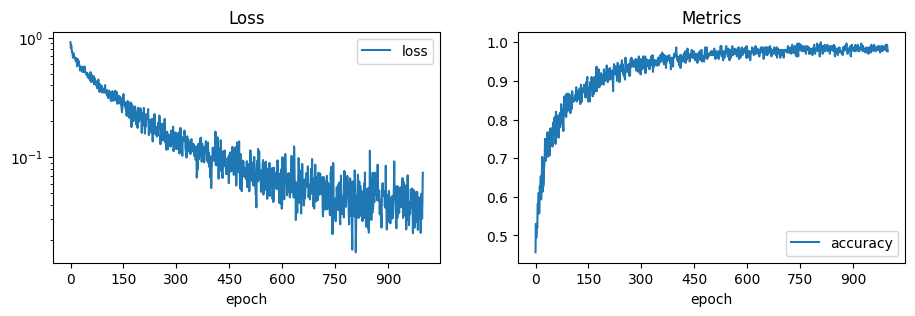

In [95]:
tinstr.plot_train_history(history)

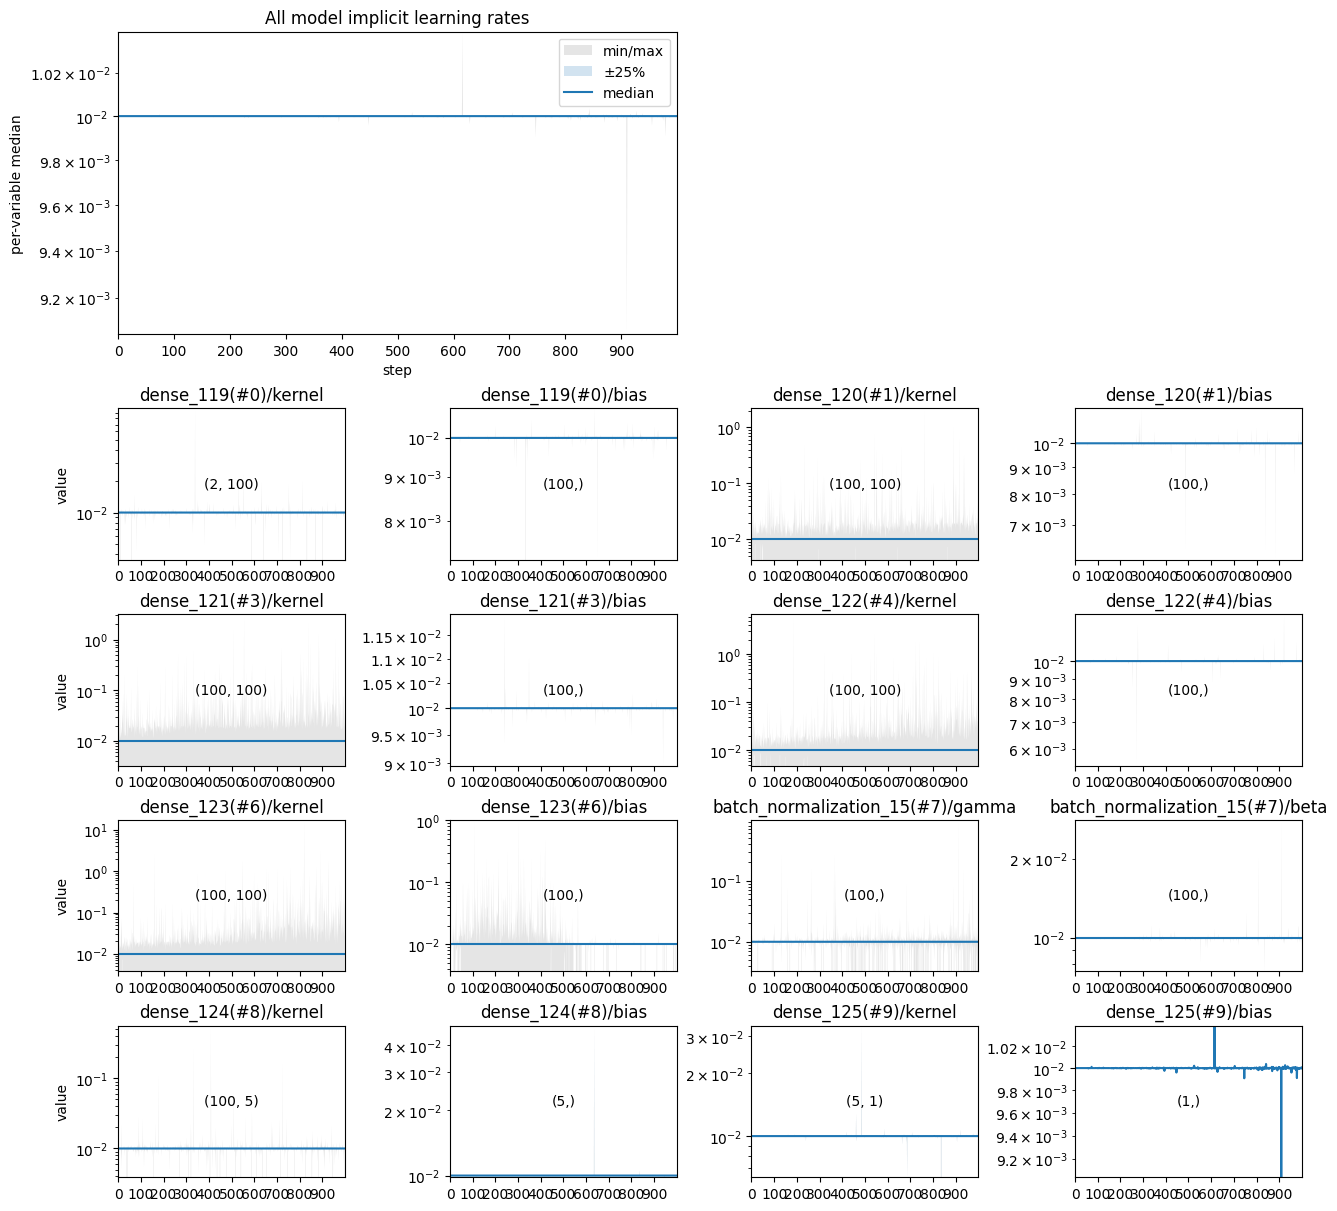

In [96]:
tinstr.plot_lr_history(ilr)

The variance in the min/max range is due to numerical errors, probably for the gradients closest to zero.

And the same with the Adam optimizer:

In [91]:
ilr = tinstr.LearningRateHistoryCallback(per_step=False)

model = binary_classification_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
dataset = tf.data.Dataset.from_tensor_slices(binary_classification_dataset()).batch(32)
history = tinstr.fit(model, dataset, epochs=1000, verbose=0, callbacks=[tinstr.LessVerboseProgressLogger(), ilr])

Epoch   100 - 241.26ms/epoch: accuracy: 0.9300  loss: 0.1895  
Epoch   200 - 198.12ms/epoch: accuracy: 0.9500  loss: 0.0930  
Epoch   300 - 203.40ms/epoch: accuracy: 0.9767  loss: 0.0854  
Epoch   400 - 190.39ms/epoch: accuracy: 0.9700  loss: 0.0588  
Epoch   500 - 198.34ms/epoch: accuracy: 0.9833  loss: 0.0399  
Epoch   600 - 194.62ms/epoch: accuracy: 0.9900  loss: 0.0316  
Epoch   700 - 192.54ms/epoch: accuracy: 0.9833  loss: 0.0450  
Epoch   800 - 197.35ms/epoch: accuracy: 0.9833  loss: 0.0321  
Epoch   900 - 200.27ms/epoch: accuracy: 0.9967  loss: 0.0082  
Epoch  1000 - 191.50ms/epoch: accuracy: 0.9867  loss: 0.0204  


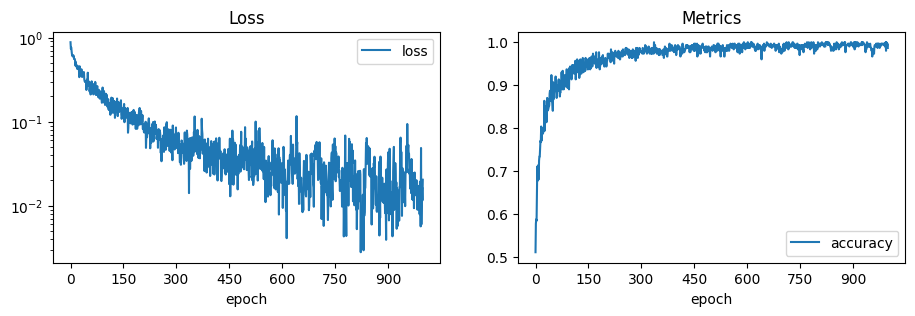

In [92]:
tinstr.plot_train_history(history)

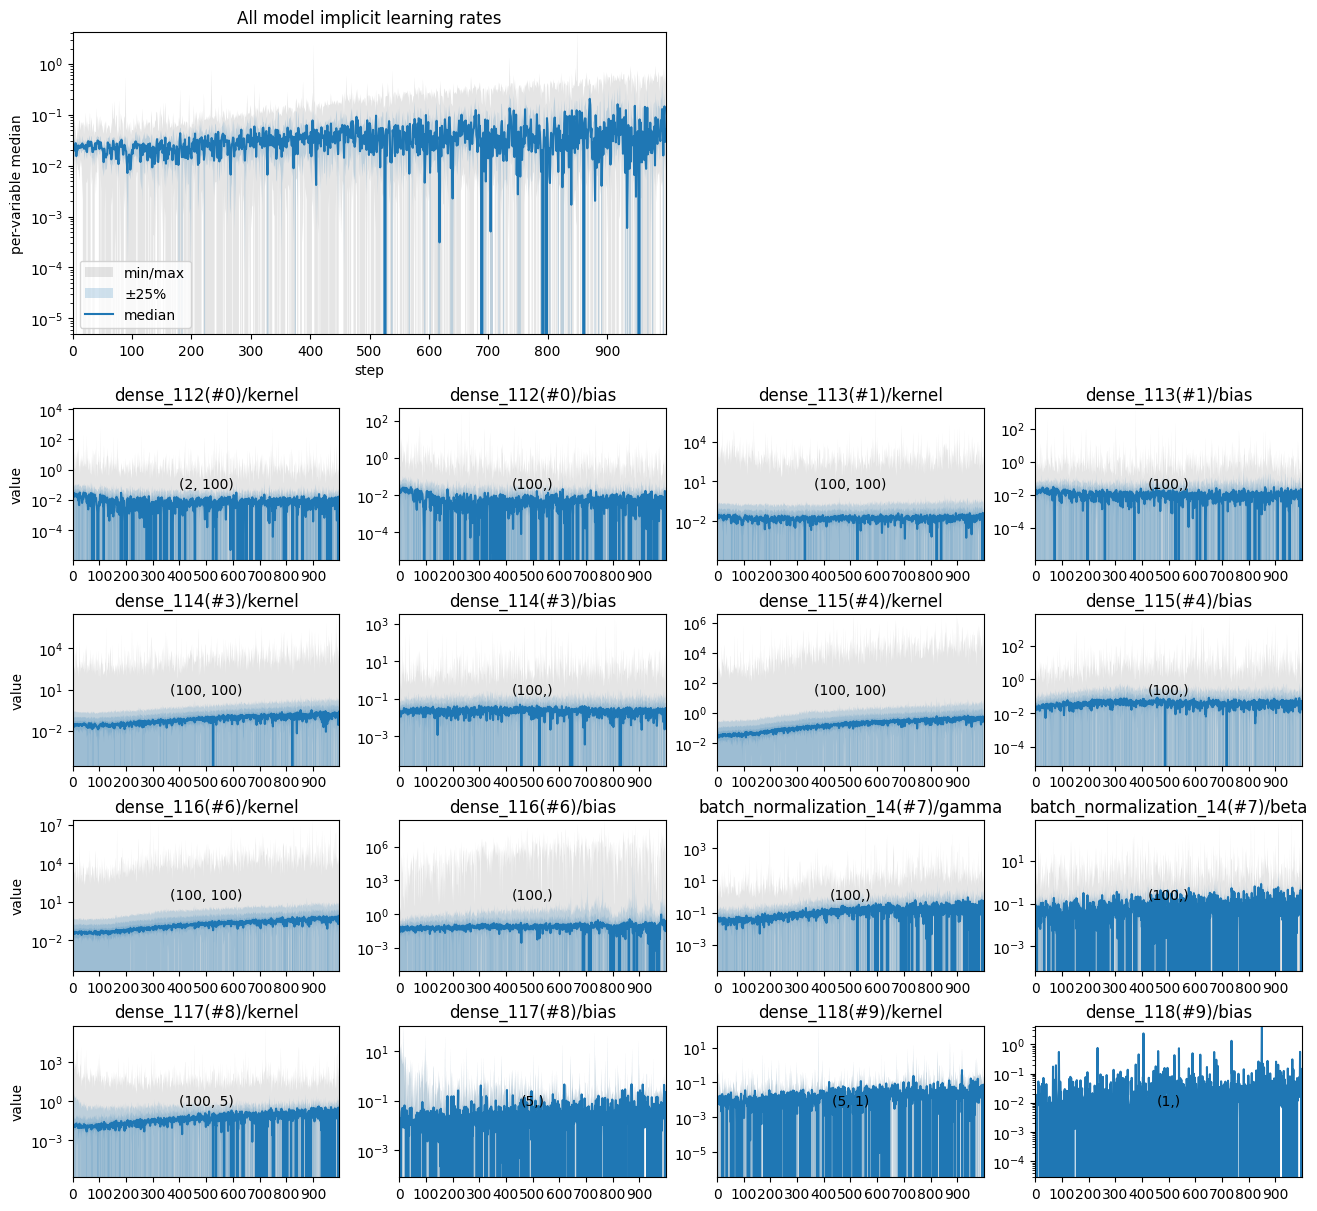

In [93]:
tinstr.plot_lr_history(ilr)

It's interesting the median implicit learning rate actually _increases_ over the course of training for many of the variables.

Finally, you can also plot the norms of the ILR values via:
```python
tinstr.plot_lr_history(ilr, show='norms')
```

However, I wouldn't recommend it. An L2-norm is heavily affected by large outliers, of which we get many for ILR. I find the norm is often 2 orders of magnitude larger than the median.